# Projeto 1 - Ciência dos Dados

Nome: Danilo Ramos

Nome: Leonardo Veras

Nome: Thomas Ganut

Atenção: Serão permitidos grupos de até 4 pessoas, mas com uma rubrica mais exigente. 

___
Carregando algumas bibliotecas:

In [24]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from IPython.display import display
import re

In [25]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
c:\Users\Leo\OneDrive - Insper - Institudo de Ensino e Pesquisa\Insper\Ciencia dos Dados\Projeto 1\C-Dados-Porreta


Carregando a base de dados com as mensagens dos seus arquivos:

In [26]:
arquivo_treino = 'dados_treino_QUARTETO_Danilo_Leonardo_Thomas.csv'
train = pd.read_csv(arquivo_treino)

train.head(5)

,Comment,Topic
0,If you pile up electrons in a hypothetical cha...,Physics
1,Is it the infamous kill-you-dead Brazilian wan...,Biology
2,What a dumb fucking question. No you moron the...,Biology
3,Yes! Humans in North America have really led ...,Biology
4,Take my award. What an underrated comment.,Chemistry


In [27]:
test = pd.read_csv('dados_teste_QUARTETO_Danilo_Leonardo_Thomas.csv')
test.head(5)

,Comment,Topic
0,Wait wouldn’t the wings rip off before the res...,Biology
1,It's pretty much the same idea behind people a...,Biology
2,"Yeah, good to know. We had a crazy infestation...",Biology
3,It’s a kiwi doggy,Biology
4,You're absolutely right about the flu not kill...,Biology


___
## Classificador automático


Faça aqui uma descrição do seu assunto e o contexto referente aos rótulos cujas mensagens (ou reviews) deverão ser classificadas.

Será desenvolvido um sistema automático, utilizando o Teorema de Bayes, para classificar textos científicos em física, química e biologia. Uma prova de conceito será implementada para treinar e testar o classificador, garantindo a separação clara dos textos nas respectivas áreas.

___
### Montando um Classificador Naive-Bayes

Considerando apenas as mensagens da planilha Treinamento, ensine  seu classificador.

In [28]:
def cleanup(text):
    """
        Função de limpeza muito simples que troca alguns sinais básicos por espaços
    """
    #import string
    punctuation = '[´"!-.:?;$'')(&€™/]' # Note que os sinais [] são delimitadores de um conjunto.
    pattern = re.compile(punctuation)
    text_subbed = re.sub(pattern, '', text)
    return text_subbed

In [29]:
list_train: list = []
for frase in train.Comment:
    frase = frase.split()
    for word in frase:
        list_train.append(word)
        
serie_train = pd.Series(list_train)
tabela = serie_train.value_counts()
stop_words = tabela.index[:10].tolist()
for i in range(len(stop_words)):
    stop_words[i] = stop_words[i].lower()
print(stop_words)


['the', 'to', 'a', 'of', 'and', 'is', 'in', 'i', 'you', 'that']


In [30]:
def cleanup_stopwords(frase):
    punctuation = '[´"!-.:?;$'')(&€™/]' # Note que os sinais [] são delimitadores de um conjunto.
    pattern = re.compile(punctuation)
    text_subbed = re.sub(pattern, '', frase.lower())
    text_subbed = text_subbed.replace(("\n"),' ')
    for palavra in stop_words:
        text_subbed = text_subbed.replace((f' {palavra} '), ' ')

    return text_subbed

print(cleanup_stopwords(' a to I of and is in you for be are with the shes contrarian who wants tear down anything she sees as being hyped this particular case shes totally right do so honestly amount bullshit surrounding delayed choice quantum eraser makes clear case sabines particular style being warranted perhaps even necessary\n\nshe gets hate because there other instances where her contrarian nature runs totally contrary what experts say  what we have pretty good reason believe her hot takes often foster misunderstanding can sometimes see her acolytes calling bullshit on say string theory or dark matter when they clearly havent taken time understand why people believe these things also there accusations she intentionally divisive increase her popular appeal sell more books which probably partially true'))

 for be are with shes contrarian who wants tear down anything she sees as being hyped this particular case shes totally right do so honestly amount bullshit surrounding delayed choice quantum eraser makes clear case sabines particular style being warranted perhaps even necessary  she gets hate because there other instances where her contrarian nature runs totally contrary what experts say  what we have pretty good reason believe her hot takes often foster misunderstanding can sometimes see her acolytes calling bullshit on say string theory or dark matter when they clearly havent taken time understand why people believe these things also there accusations she intentionally divisive increase her popular appeal sell more books which probably partially true


In [31]:
for i, frase in enumerate(train.Comment):
    train.Comment[i] = cleanup_stopwords(frase.lower())

list_train: list = []
for frase in train.Comment:
    frase = frase.split()
    for word in frase:
        list_train.append(word)
        
serie_train = pd.Series(list_train)

serie_train

0                   if
1                 pile
2                   up
3            electrons
4         hypothetical
              ...     
117010              an
117011          active
117012       untreated
117013             hiv
117014       infection
Length: 117015, dtype: object

In [32]:
train_physics = train.loc[train.Topic == 'Physics']
train_biology = train.loc[train.Topic == 'Biology']
train_chemistry = train.loc[train.Topic == 'Chemistry']

In [33]:
# Função para transformar frases em lista de palavras
def frase_para_palavras(lista_frases):
    lista_palavras = []
    for frase in lista_frases:
        lista_palavras.extend(frase.split())
    return lista_palavras

# Gerando as listas de palavras por tópico
lista_physics = frase_para_palavras(train_physics.Comment)
lista_biology = frase_para_palavras(train_biology.Comment)
lista_chemistry = frase_para_palavras(train_chemistry.Comment)

# Criando séries de frequência
serie_physics = pd.Series(lista_physics)
serie_biology = pd.Series(lista_biology)
serie_chemistry = pd.Series(lista_chemistry)


In [34]:
P_C = len(serie_chemistry)/len(serie_train)
P_B = len(serie_biology)/len(serie_train)
P_P = len(serie_physics)/len(serie_train)
print(P_C, P_B, P_P)
print(P_C + P_B + P_P)


0.30226893987950265 0.3815322821860445 0.31619877793445283
1.0


In [50]:
# Treinamento
tabela_c_relativa = serie_chemistry.value_counts(True)
tabela_p_relativa = serie_physics.value_counts(True)
tabela_b_relativa = serie_biology.value_counts(True)

voc = tabela.count()

# Physics
tabela_P_raw = serie_physics.value_counts()
tabela_P_freq = tabela_P_raw.sum()
tabela_P_voc = tabela_P_raw.count()

# Chemistry
tabela_C_raw = serie_chemistry.value_counts()
tabela_C_freq = tabela_C_raw.sum()
tabela_C_voc = tabela_C_raw.count()

# Biology
tabela_B_raw = serie_biology.value_counts()
tabela_B_freq = tabela_B_raw.sum()
tabela_B_voc = tabela_B_raw.count()


___
### Verificando a performance do Classificador

Agora você deve testar o seu classificador com a base de Testes.

In [36]:
def algoritmo_1(frase: str):
    probPalavraDadoP = 1
    probPalavraDadoC = 1
    probPalavraDadoB = 1
    lista_b = serie_biology.tolist()
    lista_p = serie_physics.tolist()
    lista_c = serie_chemistry.tolist()
    
    for palavra in frase.split():
        if palavra in lista_b:
            probPalavraDadoB *= tabela_b_relativa[palavra]
        else:
            probPalavraDadoB *= 0.000001

        if palavra in lista_p:
            probPalavraDadoP *= tabela_p_relativa[palavra]
        else:
            probPalavraDadoP *= 0.000001

        if palavra in lista_c:
            probPalavraDadoC *= tabela_c_relativa[palavra]
        else:
            probPalavraDadoC *= 0.000001

    prob_P_dado_frase = probPalavraDadoP * P_P
    prob_C_dado_frase = probPalavraDadoC * P_C
    prob_B_dado_frase = probPalavraDadoB * P_B

    # print(prob_P_dado_frase)
    # print(prob_C_dado_frase)
    # print(prob_B_dado_frase)
    # print(max(prob_P_dado_frase, prob_C_dado_frase, prob_B_dado_frase))
    # print('\n')


    if  prob_P_dado_frase > prob_C_dado_frase:
        if prob_P_dado_frase > prob_B_dado_frase:
            return 'Physics'
        else:
            return 'Biology'
    else:
        if prob_C_dado_frase > prob_B_dado_frase:
            return 'Chemistry'
        else:
            return 'Biology'
        

#frases_physics = test.loc[test.Topic == 'Physics']
#frases_chemistry = test.loc[test.Topic == 'Chemistry']
#frases_biology = test.loc[test.Topic == 'Biology']
algoritmo_1(train.Comment[1])
print(serie_biology)

0                 is
1                 it
2           infamous
3        killyoudead
4          brazilian
            ...     
44640             an
44641         active
44642      untreated
44643            hiv
44644      infection
Length: 44645, dtype: object


In [57]:
def algoritmo_laplace(frase: str):
    alpha = 1 # Suavizador de Laplace
    probPalavraDadoP, probPalavraDadoC, probPalavraDadoB = 1, 1, 1

    for palavra in frase.split():
        probPalavraDadoB *= (tabela_B_raw.get(palavra, 0) + alpha) / (tabela_B_freq + alpha * voc)

        probPalavraDadoP *= (tabela_P_raw.get(palavra, 0) + alpha) / (tabela_P_freq + alpha * voc)

        probPalavraDadoC *= (tabela_C_raw.get(palavra, 0) + alpha) / (tabela_C_freq + alpha * voc)

             
    prob_P_dado_frase = probPalavraDadoP * P_P
    prob_C_dado_frase = probPalavraDadoC * P_C
    prob_B_dado_frase = probPalavraDadoB * P_B

    if  prob_P_dado_frase > prob_C_dado_frase:
        if prob_P_dado_frase > prob_B_dado_frase:
            return 'Physics'
        else:
            return 'Biology'
    else:
        if prob_C_dado_frase > prob_B_dado_frase:
            return 'Chemistry'
        else:
            return 'Biology'

#print(tabela_c_relativa['is'])
#print(tabela_c_relativa['infamous'])
#print(tabela_c_relativa['killyoudead'])
#print(tabela_c_relativa['spider'])
#print(tabela_c_relativa['brazilian'])
#print(tabela_c_relativa['wandering'])

In [58]:
# Algoritmo com Laplace utilizando log-probabilidades
def algoritmo_laplace_log(frase: str, alpha=1):
    lista_palavras = frase.split()
    
    # Inicializar log-probabilidades com log das probabilidades das classes
    log_prob_P = np.log(P_P)
    log_prob_C = np.log(P_C)
    log_prob_B = np.log(P_B)
    
    for palavra in lista_palavras:
        # Physics
        count_p = tabela_P_raw.get(palavra, 0)
        log_prob_P += np.log((count_p + alpha) / (tabela_P_freq + alpha * voc))
        
        # Chemistry
        count_c = tabela_C_raw.get(palavra, 0)
        log_prob_C += np.log((count_c + alpha) / (tabela_C_freq + alpha * voc))
        
        # Biology
        count_b = tabela_B_raw.get(palavra, 0)
        log_prob_B += np.log((count_b + alpha) / (tabela_B_freq + alpha * voc))
    
    # Decisão baseada nas log-probabilidades
    if log_prob_P > log_prob_C:
        if log_prob_P > log_prob_B:
            return 'Physics'
        else:
            return 'Biology'
    else:
        if log_prob_C > log_prob_B:
            return 'Chemistry'
        else:
            return 'Biology'

In [38]:
frase_teste = cleanup_stopwords('honestly amount bullshit surrounding delayed choice quantum eraser makes clear case sabines particular style being warranted perhaps even necessary\n\nshe gets hate because there other instances where her contrarian nature runs totally contrary what experts say  what we have pretty good reason believe her hot takes often foster misunderstanding can sometimes see her acolytes calling bullshit on say string theory or dark matter when they clearly havent taken time understand')
print(frase_teste)
print('Sem Laplace: \n', algoritmo_1(frase_teste), '\n')
print('Com Laplace: \n', algoritmo_laplace(frase_teste))

honestly amount bullshit surrounding delayed choice quantum eraser makes clear case sabines particular style being warranted perhaps even necessary  she gets hate because there other instances where her contrarian nature runs totally contrary what experts say  what we have pretty good reason believe her hot takes often foster misunderstanding can sometimes see her acolytes calling bullshit on say string theory or dark matter when they clearly havent taken time understand
Sem Laplace: 
 Physics 

Com Laplace: 
 Physics


In [59]:
validacao = test.copy()
validacao['algo1_certa'] = 'NaN'
validacao['algoL_certa'] = 'NaN'
validacao['algoL_log_certa'] = 'NaN'

validacao['algo1'] = 'NaN'
validacao['algoL'] = 'NaN'
validacao['algoL_log'] = 'NaN'

for i, frase in enumerate(test.Comment):
    frase = cleanup_stopwords(frase)
    validacao['algo1'][i] = algoritmo_1(frase)
    validacao['algoL'][i] = algoritmo_laplace(frase)
    validacao['algoL_log'][i] = algoritmo_laplace_log(frase)

  
    if validacao['algo1'][i] == validacao['Topic'][i]:
        validacao['algo1_certa'][i] = True
    else:
        validacao['algo1_certa'][i] = False

    if validacao['algoL'][i] == validacao['Topic'][i]:
        validacao['algoL_certa'][i] = True
    else:
        validacao['algoL_certa'][i] = False

    if validacao['algoL_log'][i] == validacao['Topic'][i]:
        validacao['algoL_log_certa'][i] = True
    else:
        validacao['algoL_log_certa'][i] = False

# validacao.head(15)


In [60]:
acertos_algo1 = validacao.algo1_certa.value_counts(True)
acertos_algoL = validacao.algoL_certa.value_counts(True)
acertos_algoL_log = validacao.algoL_log_certa.value_counts(True)

print('Acertos sem Laplace: ')
print(f'{acertos_algo1[True]*100:.2f}%')
print('\nAcertos com Laplace:')
print(f'{acertos_algoL[True]*100:.2f}%')
print('\nAcertos com Laplace com log:')
print(f'{acertos_algoL_log[True]*100:.2f}%')

Acertos sem Laplace: 
68.06%

Acertos com Laplace:
68.56%

Acertos com Laplace com log:
71.61%


In [41]:
display(pd.crosstab(test.Topic, validacao.algo1_certa))
display(pd.crosstab(test.Topic, validacao.algoL_certa))

taxa_acerto_1 = [validacao.algo1_certa.value_counts()[0], validacao.algo1_certa.value_counts()[1]]

#Análise Biologia
validacao_biologia = validacao.loc[validacao.Topic == 'Biology']
taxa_acerto_bio_L = validacao_biologia.algoL.value_counts(True)[0]
validacao_biologia_algoL_acertos = validacao_biologia.algoL.value_counts()[0]
taxa_acerto_bio_1 = validacao_biologia.algo1.value_counts(True)[0]
print(f' Taxa de acertos em biologia com Laplace: {taxa_acerto_bio_L}','\n', f'Taxa de acertos em biologia sem Laplace: {taxa_acerto_bio_1}')
print('\n')

#Análise Física
validacao_physics = validacao.loc[validacao.Topic == 'Physics']
taxa_acerto_ph_L = validacao_physics.algoL.value_counts(True)[0]
taxa_acerto_ph_1 = validacao_physics.algo1.value_counts(True)[0]
print(f' Taxa de acertos em física com Laplace: {taxa_acerto_ph_L}', '\n', f'Taxa de acertos em física sem Laplace: {taxa_acerto_ph_1}')
print('\n')

#Análise Química
validacao_chemistry = validacao.loc[validacao.Topic == 'Chemistry']
taxa_acerto_ch_L = validacao_chemistry.algoL.value_counts(True)[0]
taxa_acerto_ch_1 = validacao_chemistry.algo1.value_counts(True)[0]
print(f' Taxa de acertos em química com Laplace: {taxa_acerto_ph_L}','\n', f'Taxa de acertos em química sem Laplace: {taxa_acerto_ph_1}')

algo1_certa,False,True
Topic,,
Biology,153,584
Chemistry,228,370
Physics,194,271


algoL_certa,False,True
Topic,,
Biology,125,612
Chemistry,243,355
Physics,198,267


 Taxa de acertos em biologia com Laplace: 0.830393487109905 
 Taxa de acertos em biologia sem Laplace: 0.7924016282225237


 Taxa de acertos em física com Laplace: 0.5741935483870968 
 Taxa de acertos em física sem Laplace: 0.5827956989247312


 Taxa de acertos em química com Laplace: 0.5741935483870968 
 Taxa de acertos em química sem Laplace: 0.5827956989247312


C:\Users\Leo\AppData\Local\Temp\ipykernel_45212\2604824812.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  taxa_acerto_1 = [validacao.algo1_certa.value_counts()[0], validacao.algo1_certa.value_counts()[1]]
C:\Users\Leo\AppData\Local\Temp\ipykernel_45212\2604824812.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  taxa_acerto_1 = [validacao.algo1_certa.value_counts()[0], validacao.algo1_certa.value_counts()[1]]
C:\Users\Leo\AppData\Local\Temp\ipykernel_45212\2604824812.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as lab

Topic,Biology
algoL_certa,
False,125
True,612


<Figure size 640x480 with 0 Axes>

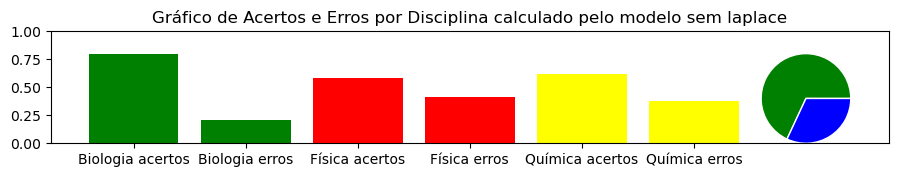

In [42]:
cross_L = pd.crosstab(validacao_biologia.Topic, validacao_biologia.algoL_certa)
display(pd.crosstab(validacao_biologia.algoL_certa, validacao_biologia.Topic))
plt.figure()

fig, ax = plt.subplots(figsize=(9, 15))

categorias = ['Biologia acertos', 'Biologia erros', 'Física acertos', 'Física erros', 'Química acertos', 'Química erros']
posicoes = np.arange(1,len(categorias) + 1)

ax.bar(1, taxa_acerto_bio_1, color='Green')
ax.bar(2, (1 - taxa_acerto_bio_1), color='Green')
ax.bar(3, taxa_acerto_ph_1, color='Red')
ax.bar(4, (1 - taxa_acerto_ph_1), color='Red')

ax.bar(5, taxa_acerto_ch_1, color='yellow')
ax.bar(6, (1 - taxa_acerto_ch_1), color='yellow')

ax.pie(taxa_acerto_1, colors=['Green','Blue'], radius=0.4, center=(7, 0.4),
       wedgeprops={"linewidth": 1, "edgecolor": "white"}, frame=True)

ax.set_ylim(0, 1)
plt.xticks(posicoes, categorias, ha='center')
plt.title('Gráfico de Acertos e Erros por Disciplina calculado pelo modelo sem laplace')
plt.tight_layout()  # Ajusta para evitar sobreposição

plt.show()

___
### Concluindo

___
### Qualidade do Classificador a partir de novas separações das mensagens entre Treinamento e Teste

Caso for fazer esse item do Projeto

___
## Aperfeiçoamento:

Leia atentamente a rubrica colocada no enunciado do Projeto 1 (última página). <br>
Trabalhos que conseguirem pelo menos conceito B vão evoluir em conceito dependendo da quantidade de itens avançados:

* IMPLEMENTOU outras limpezas e transformações que não afetem a qualidade da informação contida nas mensagens, mas tendem a melhorar na classificação das mensagens. Ex: stemming, lemmatization, stopwords.
* CONSIDEROU arquivo com três categorias na classificação das variáveis (OBRIGATÓRIO PARA QUARTETOS, sem contar como item avançado)
* CONSTRUIU o cálculo das probabilidades corretamente utilizando bigramas E apresentou referência sobre o método utilizado.
* EXPLICOU porquê não pode usar novas mensagens classificadas pelo próprio classificador como amostra de treinamento
* PROPÔS diferentes cenários para Naïve Bayes fora do contexto do projeto (pelo menos dois cenários diferentes, exceto aqueles já apresentados em sala pelos professores: por exemplo, filtro de spam)
* REFLETE criticamente sobre os resultados obtidos, identificando limitações do modelo e sugerindo possíveis melhorias ou diferentes abordagens com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa).
* DOCUMENTOU bem o código, com explicações claras para cada etapa do processo, incluindo o raciocínio por trás das decisões de modelagem e das transformações de dados.


___
## Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**